# Очистка данных

In [212]:
import pandas as pd
from decimal import Decimal
from sklearn.utils import shuffle
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from pymorphy2 import MorphAnalyzer
from tqdm import tqdm 
from datetime import datetime, date

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from pylab import rcParams

import torch
import torch.nn as nn

from transformers import (
    AdamW,
    AutoTokenizer, 
    pipeline,
    AutoModel,
    AutoConfig,
    AutoModelForSequenceClassification, 
    AutoModelForTokenClassification,
    DataCollatorForLanguageModeling, 
    get_scheduler,
    Trainer, 
    TrainingArguments
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

[nltk_data] Error loading stopwords: <urlopen error [WinError 10061]
[nltk_data]     Подключение не установлено, т.к. конечный компьютер
[nltk_data]     отверг запрос на подключение>


In [147]:
#main_df = pd.read_csv('https://github.com/skillfactory-hackaton-team9/twitter-analyzer/blob/42013f305a5d51a94a5260353e15bb04635e8a03/parsed_data/sentiment_from_2_models.csv',index_col=0)
main_df = pd.read_csv('twitter_new_raw_data.csv',index_col=0)
main_df.head(5)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes
0,2022-07-22T20:22:11.000Z,Светлана,@Svetlan99809534,"по оценке журнала «Forbes» Керимов стал третьим в рейтинге людей России, тративших деньги на благотворительность Фонд сотрудничает с благотворительными организациями Фонд «Подари Жизнь», Фонд Горчакова, Фонд Здоровье нации, и другие.",0,0,0
1,2022-07-18T12:17:28.000Z,Серж,@eATOuWB6hfHqVpc,"Хаматова в свой фонд подари жизнь по 1млрд в год получала, по сто миллионов тратила на административку. ФБК получали по охулиарду. Че не так-то?))",0,0,4
2,2022-07-04T05:47:11.000Z,ленаelena,@elena53166542,"У Хаматовой денег море. Она обокрал фонд Подари жизнь. Там начались проверки, недостача миллиард, Потому и сбежала. Но надо сказать, что денег нет.",2,0,1
3,2022-07-02T19:22:11.000Z,Dre1,@DremanerDre1,"Мих, ты не ""Лёняверим"", может кто-либо из твоих фолловеров?\nhttps://mobile.twitter.com/DremanerDre1/status/1463069084829077505…\n\nДавайте так, эквивалент суммы перечислить в благотворительный фонд: ""Спартак-детям"", ""Подари жизнь"" и тд.\n\nА вы, пасаны @BillyBons78 @shuvach8 @SoyuzAppolon , готовьтесь перечислить ребятишкам.",0,0,0
4,2022-07-01T18:44:57.000Z,"Wishmaster© Vendetta,",–,"Дебиторская задолженность фонда «Подари жизнь», известного как фонд актрисы Чулпан Хаматовой, за 2021 год составила более одного миллиарда рублей. Об этом в своем telegram-канале сообщает российский журналист Эдвард Чесноков.\nhttps://t.me/chesnokmedia/8027…",0,1,3


In [148]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2533 entries, 0 to 2532
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                2533 non-null   object
 1   author              2533 non-null   object
 2   twitter_name        2533 non-null   object
 3   text                2533 non-null   object
 4   number_of_reply     2533 non-null   int64 
 5   number_of_retweets  2533 non-null   int64 
 6   number_of_likes     2533 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 158.3+ KB


<AxesSubplot:>

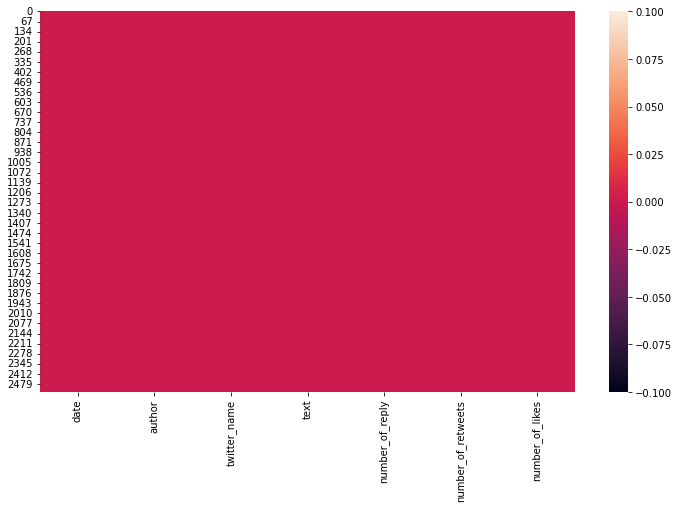

In [149]:
plt.subplots(figsize=(12, 7))
sns.heatmap(main_df.isnull())

In [150]:
main_df = shuffle(main_df)
main_df.reset_index(inplace=True, drop=True)
main_df.head()

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes
0,2012-11-24T03:12:52.000Z,Modnov Semen,@Modnov24,"Фонд ""Подари жизнь"" получит от властей участок под детский хоспис http://paetemidlo.tumblr.com/post/35995992237…",0,0,0
1,2015-09-22T04:07:25.000Z,Жандос Сеит,@Zhandik,"Мне понравилось видео ""Подари детям Жизнь. фильм третий. Аутизм. Фонд ДОМ""",0,0,0
2,2017-10-27T09:30:13.000Z,Медвестник,@Med_vestnik,Фонд «Подари жизнь» заявил о правовом вакууме в отношении трансплантации костного мозга детям https://medvestnik.ru/content/news/Podari-jizn-zayavil-o-pravovom-vakuume-v-otnoshenii-transplantacii-kostnogo-mozga-detyam.html…,0,0,0
3,2017-02-13T05:57:59.000Z,Anna,@C_a_l_i_p_s_o,#charityfair#благотворительнаяярмарка#PodariZhisn#фондПодариЖизнь\nWe sent 25000Rur - our charity fair proceeds... http://fb.me/5TjHJ1zAy,0,0,0
4,2014-01-20T17:54:40.000Z,Татьяна,@leyamonstr,"@StalinGulag даже фонд ""Подари жизнь"" начинает сбор средств, когда бедным родителям уже продавать нечего. А тут сразу. А еще вчера все врали",0,0,0


In [151]:
main_df['date'] = main_df['date'].apply(lambda x: x.split('T')[0])
main_df['date'] = main_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime("%d.%m.%Y"))
main_df['date'] = main_df['date'].apply(lambda x: datetime.strptime(x, "%d.%m.%Y"))
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes
0,2012-11-24,Modnov Semen,@Modnov24,"Фонд ""Подари жизнь"" получит от властей участок под детский хоспис http://paetemidlo.tumblr.com/post/35995992237…",0,0,0
1,2015-09-22,Жандос Сеит,@Zhandik,"Мне понравилось видео ""Подари детям Жизнь. фильм третий. Аутизм. Фонд ДОМ""",0,0,0


In [152]:
def clear_text(text: str):
    clear_text = re.sub(r'[^А-яЁё]+', ' ', text).lower()
    return ' '.join(clear_text.split())

In [153]:
main_df['text'] = main_df['text'].apply(clear_text)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes
0,2012-11-24,Modnov Semen,@Modnov24,фонд подари жизнь получит от властей участок под детский хоспис,0,0,0
1,2015-09-22,Жандос Сеит,@Zhandik,мне понравилось видео подари детям жизнь фильм третий аутизм фонд дом,0,0,0


In [154]:
def clean_stop_words(text : str):
    stop = stopwords.words('russian')
    stop.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...', '>', 'донорыдеть'])
    text = [word for word in text.split() if word not in stop]
    return " ".join(text)

In [155]:
main_df['text'] = main_df['text'].apply(clean_stop_words)
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes
0,2012-11-24,Modnov Semen,@Modnov24,фонд подари жизнь получит властей участок детский хоспис,0,0,0
1,2015-09-22,Жандос Сеит,@Zhandik,понравилось видео подари детям жизнь фильм третий аутизм фонд дом,0,0,0


In [156]:
morph = MorphAnalyzer()
main_df['text'] = main_df['text'].apply(lambda x: morph.normal_forms(x)[0])
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes
0,2012-11-24,Modnov Semen,@Modnov24,фонд подари жизнь получит властей участок детский хоспис,0,0,0
1,2015-09-22,Жандос Сеит,@Zhandik,понравилось видео подари детям жизнь фильм третий аутизм фонд д,0,0,0


In [157]:
#Add new feature to DF 'text_lengh'
main_df['text_lengh'] = main_df['text'].apply(lambda x: len(x.strip(' ')))
main_df.head(2)

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,text_lengh
0,2012-11-24,Modnov Semen,@Modnov24,фонд подари жизнь получит властей участок детский хоспис,0,0,0,56
1,2015-09-22,Жандос Сеит,@Zhandik,понравилось видео подари детям жизнь фильм третий аутизм фонд д,0,0,0,63


# Частотный анализ

In [158]:
Twitter = CountVectorizer(ngram_range=(1, 1))
Twitter_count = Twitter.fit_transform(main_df['text'])
Twitter_frequence = pd.DataFrame({'word':Twitter.get_feature_names(),'frequency':np.array(Twitter_count.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main = Twitter_frequence[:100]

In [159]:
Twitter_frequence_main

,word,frequency
6531,фонд,2419
1600,жизнь,2394
4096,подари,2374
315,благотворительный,396
6804,чулпан,243
...,...,...
4620,приглашает,24
6587,хабенского,24
376,больных,24
5666,собрали,23


In [160]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main.values))

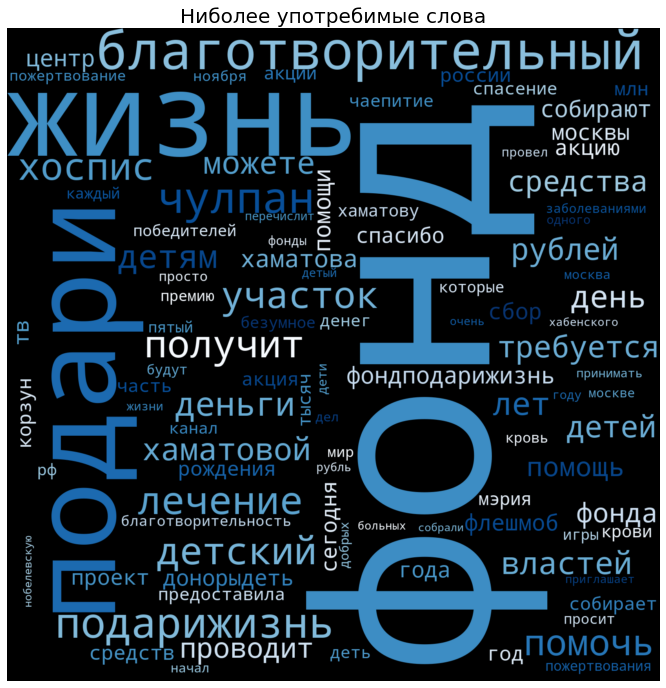

In [161]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Ниболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

In [162]:
def text2toxicity(text, aggregate=False):
    """ Calculate toxicity of a text (if aggregate=True) or a vector of toxicity aspects (if aggregate=False)"""
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba[1]

In [163]:
MODEL_NAME = 'SkolkovoInstitute/russian_toxicity_classifier'

In [164]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
if torch.cuda.is_available():
    model.cuda()

In [165]:
main_df.text.head(10).apply(text2toxicity)

0    0.022442
1    0.024050
2    0.048171
3    0.049041
4    0.033144
5    0.045913
6    0.024146
7    0.094674
8    0.022581
9    0.125446
Name: text, dtype: float32

In [166]:
main_df.text.head(10)

0    фонд подари жизнь получит властей участок детский хоспис                                                            
1    понравилось видео подари детям жизнь фильм третий аутизм фонд д                                                     
2    фонд подари жизнь заявил правовом вакууме отношении трансплантации костного мозга деть                              
3    благотворительнаяярмарка фондподарижизнь                                                                            
4    фонд подари жизнь начинает сбор средств бедным родителям продавать нечего сразу вчера врать                         
5    фонд подари жизнь проводит флешмоб донорыдеть                                                                       
6    лондоне открылся фонд подари жизнь                                                                                  
7    видела наших обливавшихся пожертвовал деньги фонд подари жизнь левандовски например польский фонд                   
8    благотворительный ф

In [167]:
sentiment = main_df.text.apply(text2toxicity)
sentiment

0       0.022442
1       0.024050
2       0.048171
3       0.049041
4       0.033144
          ...   
2528    0.033276
2529    0.049669
2530    0.024036
2531    0.031330
2532    0.021683
Name: text, Length: 2533, dtype: float32

In [168]:
sentiment = sentiment.apply(lambda x: int(1) if Decimal(x) > Decimal(0.5) else int(0))
sentiment

0       0
1       0
2       0
3       0
4       0
       ..
2528    0
2529    0
2530    0
2531    0
2532    0
Name: text, Length: 2533, dtype: int64

In [169]:
df_to_analize = pd.concat([main_df, sentiment], ignore_index=True, axis=1)
df_to_analize = df_to_analize.rename(columns={0:'date', 1:'author', 2:'twitter_name', 3:'text', 4:'number_of_reply', 5:'number_of_retweets', 6:'number_of_likes', 7:'text_lengh', 8:'negative'})
df_to_analize.head()

,date,author,twitter_name,text,number_of_reply,number_of_retweets,number_of_likes,text_lengh,negative
0,2012-11-24,Modnov Semen,@Modnov24,фонд подари жизнь получит властей участок детский хоспис,0,0,0,56,0
1,2015-09-22,Жандос Сеит,@Zhandik,понравилось видео подари детям жизнь фильм третий аутизм фонд д,0,0,0,63,0
2,2017-10-27,Медвестник,@Med_vestnik,фонд подари жизнь заявил правовом вакууме отношении трансплантации костного мозга деть,0,0,0,86,0
3,2017-02-13,Anna,@C_a_l_i_p_s_o,благотворительнаяярмарка фондподарижизнь,0,0,0,40,0
4,2014-01-20,Татьяна,@leyamonstr,фонд подари жизнь начинает сбор средств бедным родителям продавать нечего сразу вчера врать,0,0,0,91,0


In [170]:
# Количество лайков по выборке
print(df_to_analize.number_of_likes.sum(),df_to_analize.number_of_likes.mean())

6038 2.3837347019344652


In [171]:
# Количество ретвитов по выборке
print(df_to_analize.number_of_retweets.sum(),df_to_analize.number_of_retweets.mean())

2988 1.1796288985392815


In [172]:
df_to_analize.negative.value_counts()

0    2508
1    25  
Name: negative, dtype: int64

In [173]:
df_to_analize.to_csv('prepared_data.csv')

## Оценка негативных отзывов

In [174]:
df_to_analize_neg = df_to_analize.loc[df_to_analize['negative']==1]

In [175]:
Twitter_neg = CountVectorizer(ngram_range=(1, 1))
Twitter_count_neg = Twitter_neg.fit_transform(df_to_analize_neg['text'])
Twitter_frequence_neg = pd.DataFrame({'word':Twitter_neg.get_feature_names(),'frequency':np.array(Twitter_count_neg.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main_neg = Twitter_frequence_neg[:10]

In [176]:
wordcloud_Twitter_neg = WordCloud(background_color="black",
                               colormap = 'Reds',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main_neg.values))

In [177]:
Twitter_frequence_main_neg

,word,frequency
223,фонд,22
128,подари,21
61,жизнь,20
224,фондподарижизнь,4
86,людей,3
10,бить,3
45,детей,3
25,всё,3
66,запретили,2
107,ненавижу,2


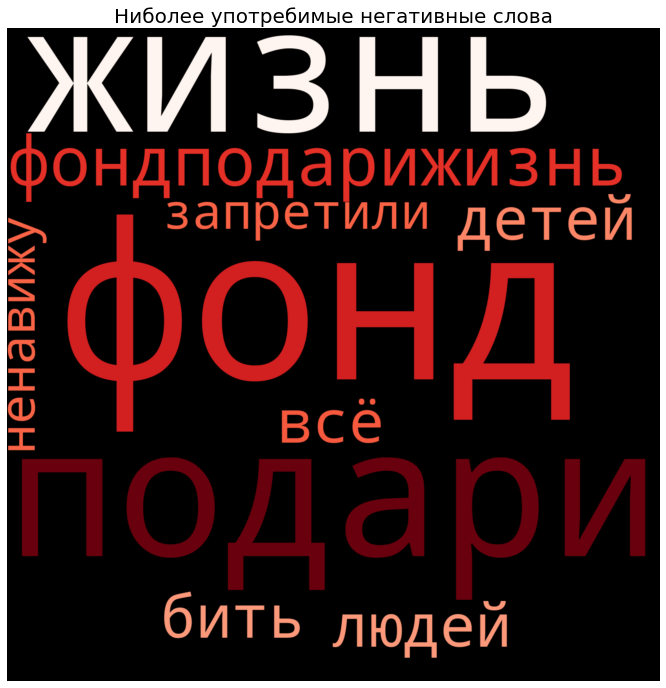

In [178]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter_neg, interpolation='bilinear')
ax.set_title('Ниболее употребимые негативные слова', fontsize = 20)
ax.axis("off")

plt.show()

In [179]:
# Суть негатиивных отзывов не ясна. Вероятно как-то связаны с представителем фондв Чулпан Хаматовой и денежными проблемамию
pd.set_option('display.max_colwidth', -1)
df_to_analize_neg.loc[df_to_analize_neg['date']>'2022-01-01'].text

C:\WINDOWS\TEMP/ipykernel_13528/3009590406.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


400     душераздирающее интервью гордеевой последняя подстилка путинского режима опомнилась фонд подари жизнь всё                                                                                        
473     какую выгоду получила фонд подари жизнь иностранными агентом признали тюрьму бросили мудаки честное словый                                                                                       
712     непопулярное мнение ненавижу фонд подари жизнь работал пропаганда телеку больными детьми кризиса детей людей россии умрет намнооого спасли ненавижу пусть переобувается поможет хуйлу свалить    
1109    дима антоном поддержавшие фонд подари жизнь спасли мое уебское настроение                                                                                                                        
1764    чулпан хаматова эмигрировала латвию сказала боится возвращаться россию почему угодили фонд подари жизнь вышла гниль проявилась явно кстати реклама тв какие премии получала двуличная пр

Анализ негативных отзывов  за последнее время показывает, что негативные отзывы, 
по-преимуществу, связаны с политической позицией представителя фонда и не имеют никакого отношения к деятельности фонда

В связи с тем, что позитивные отзывы сосмтавляют подавляющее большинство, то результат будет мало отличаться от предвтавленного выше анализа данных в целом.

## Логистическая регрессия 

In [198]:
df_to_analize_2 = df_to_analize[['text','negative']]
df_to_analize_2.head(2)

,text,negative
0,фонд подари жизнь получит властей участок детский хоспис,0
1,понравилось видео подари детям жизнь фильм третий аутизм фонд д,0


In [199]:
train, test = train_test_split(df_to_analize_2,test_size = 0.2,stratify = df_to_analize_2['negative'])
counter_idf = TfidfVectorizer(ngram_range=(1,1))
count_train = counter_idf.fit_transform(train['text'])
count_test = counter_idf.transform(test['text'])

In [201]:
model_lr = LogisticRegression(random_state = 12345,
                                    max_iter = 10000,
                                    n_jobs = -1)

model_lr.fit(count_train, train['negative'])
predict_count_proba = model_lr.predict_proba(count_test)

In [210]:
weights = pd.DataFrame({'words': counter_idf.get_feature_names(),
                        'weights': model_lr.coef_.flatten()})
weights_min = weights.sort_values(by= 'weights')[:50]
weights_max = weights.sort_values(by= 'weights', ascending = False)[:50]

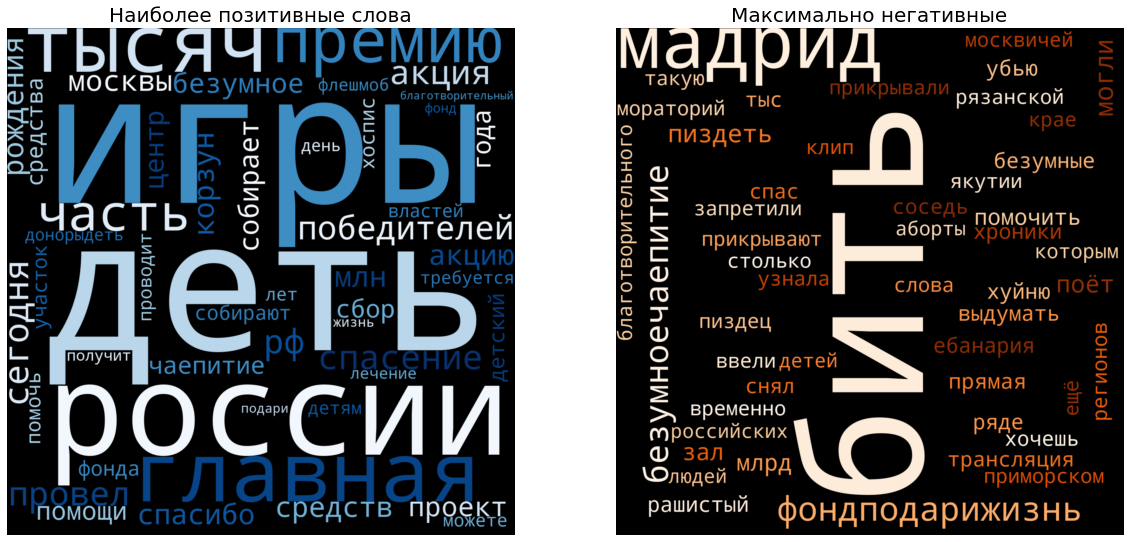

In [211]:
wordcloud_min = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_min.values))

wordcloud_max = WordCloud(background_color="black",
                               colormap = 'Oranges',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(weights_max.values))


fig, ax = plt.subplots(1, 2, figsize = (20, 12))


ax[0].imshow(wordcloud_min, interpolation='bilinear')
ax[1].imshow(wordcloud_max, interpolation='bilinear')

ax[0].set_title('Наиболее позитивные слова',
               fontsize = 20
               )
ax[1].set_title('Максимально негативные',
               fontsize = 20
               )

ax[0].axis("off")
ax[1].axis("off")

plt.show()

## Reaction analyze

In [132]:
new_df = df_to_analize.loc[(df_to_analize['number_of_retweets'] >=3) | (main_df["number_of_likes"] >=3)]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 3 to 1102
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                200 non-null    datetime64[ns]
 1   author              200 non-null    object        
 2   twitter_name        200 non-null    object        
 3   text                200 non-null    object        
 4   number_of_reply     200 non-null    int64         
 5   number_of_retweets  200 non-null    int64         
 6   number_of_likes     200 non-null    int64         
 7   text_lengh          200 non-null    int64         
 8   negative            200 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 15.6+ KB


In [133]:
Twitter = CountVectorizer(ngram_range=(1, 1))
Twitter_count = Twitter.fit_transform(new_df['text'])
Twitter_frequence = pd.DataFrame({'word':Twitter.get_feature_names(),'frequency':np.array(Twitter_count.sum(axis = 0))[0]}).sort_values(by = 'frequency', ascending = False)
Twitter_frequence_main = Twitter_frequence[:100]

In [134]:
Twitter_frequence_main

,word,frequency
1544,фонд,207
377,жизнь,191
967,подари,190
65,благотворительный,34
277,день,23
...,...,...
494,канала,4
1139,пройдет,3
148,впервые,3
152,время,3


In [135]:
wordcloud_Twitter = WordCloud(background_color="black",
                               colormap = 'Blues',
                               max_words=200,
                               mask=None, 
                               width=1600,
                               height=1600)\
                        .generate_from_frequencies(
                            dict(Twitter_frequence_main.values))

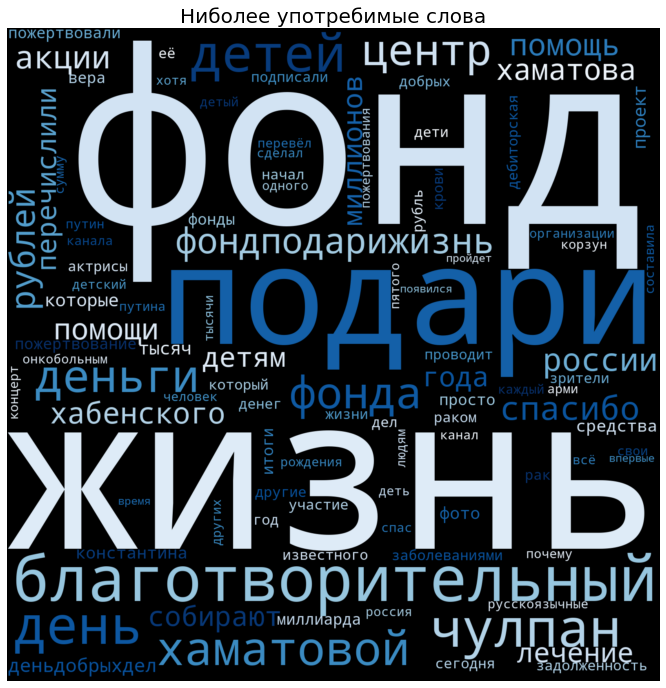

In [136]:
fig, ax = plt.subplots(1, figsize = (20, 12))

ax.imshow(wordcloud_Twitter, interpolation='bilinear')
ax.set_title('Ниболее употребимые слова', fontsize = 20)
ax.axis("off")

plt.show()

In [137]:
new_df.negative.value_counts()

0    193
1    7  
Name: negative, dtype: int64

In [138]:
new_df_neg = new_df.loc[new_df['negative']==1]

In [139]:
pd.set_option('display.max_colwidth', -1)
df_to_analize_neg.loc[df_to_analize_neg['date']>'2022-01-01'].text

C:\WINDOWS\TEMP/ipykernel_13528/785274429.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


163     вата чулпан сравнил фонд подари жизнь спас тысячи детей сделал прокурор блять ненавидим муратова слова отдал премию фонд путина спасённых детей ройзману чулпан одна представителем путин                                                         
298     дима антоном поддержавшие фонд подари жизнь спасли мое уебское настроение                                                                                                                                                                         
453     фонд подари жизнь чулпан хаматовой г спас тыс детей пиздеть                                                                                                                                                                                       
460     пиздец узнала подари жизнь которым столько прикрывали прикрывают хаматову фонд хаматовый                                                                                                                                                       

In [143]:
print(new_df_neg.number_of_likes.sum(),new_df_neg.number_of_likes.mean())

453 64.71428571428571


In [144]:
print(new_df_neg.number_of_retweets.sum(),new_df_neg.number_of_retweets.mean())

126 18.0


Можно отметить, что выявленные выше негативные отзывы довольно популярны и на порядки превосходят количество лайков и ретвитов в реднем по выборке. В связи с тем, что зачительное число таких отзывов приходится на последний год (10/23), то репутация фонда стремительно ухудшается.

In [186]:
new_df_10 = df_to_analize.loc[(df_to_analize['number_of_retweets'] >=10) | (main_df["number_of_likes"] >=10)]
new_df_10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109 entries, 86 to 2530
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                109 non-null    datetime64[ns]
 1   author              109 non-null    object        
 2   twitter_name        109 non-null    object        
 3   text                109 non-null    object        
 4   number_of_reply     109 non-null    int64         
 5   number_of_retweets  109 non-null    int64         
 6   number_of_likes     109 non-null    int64         
 7   text_lengh          109 non-null    int64         
 8   negative            109 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 8.5+ KB


In [187]:
new_df_10.negative.value_counts()

0    105
1    4  
Name: negative, dtype: int64

In [188]:
new_df_20 = df_to_analize.loc[(df_to_analize['number_of_retweets'] >=20) | (main_df["number_of_likes"] >=20)]
new_df_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 168 to 2530
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                56 non-null     datetime64[ns]
 1   author              56 non-null     object        
 2   twitter_name        56 non-null     object        
 3   text                56 non-null     object        
 4   number_of_reply     56 non-null     int64         
 5   number_of_retweets  56 non-null     int64         
 6   number_of_likes     56 non-null     int64         
 7   text_lengh          56 non-null     int64         
 8   negative            56 non-null     int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 4.4+ KB


In [189]:
new_df_20.negative.value_counts()

0    52
1    4 
Name: negative, dtype: int64

In [190]:
new_df_30 = df_to_analize.loc[(df_to_analize['number_of_retweets'] >=30) | (main_df["number_of_likes"] >=30)]
new_df_30.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 261 to 2530
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                41 non-null     datetime64[ns]
 1   author              41 non-null     object        
 2   twitter_name        41 non-null     object        
 3   text                41 non-null     object        
 4   number_of_reply     41 non-null     int64         
 5   number_of_retweets  41 non-null     int64         
 6   number_of_likes     41 non-null     int64         
 7   text_lengh          41 non-null     int64         
 8   negative            41 non-null     int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 3.2+ KB


In [191]:
new_df_30.negative.value_counts()

0    38
1    3 
Name: negative, dtype: int64

Приведенная выше информация показывает, что негативные отзывы находятся среди самых популярных. Однако их число не превышает десятой части всех отзывов.